# Integrate-and-fire with adaptation

The Integrate-and-Fire with Adaptation (AELIF) model extends the basic leaky integrate-and-fire model by incorporating an adaptation mechanism. This adaptation reduces excitability after spiking, enabling the neuron to adapt its firing rate in response to sustained input.

## Key Properties

1. **Spike-Frequency Adaptation**: Firing rate decreases during sustained stimulation
2. **Post-Burst Refractoriness**: Reduced excitability after periods of intense activity
3. **Diverse Firing Patterns**: Can exhibit regular spiking, adaptation, and bursting behaviors
4. **Input-Frequency Dynamics**: Response depends on input history, not just current input

## Mathematical Description

The model is described by two coupled differential equations:

Cm(dV/dt) = -gL(V - EL) - w + Iext

When V ≥ Vth:
  • V is reset to Vreset
  • w is incremented: w = w + b

Adaptation dynamics:
tau_w(dw/dt) = a(V - EL) - w

Parameters:
- V: Membrane potential
- w: Adaptation variable (represents slow K+ currents and other adaptation mechanisms)
- Cm: Membrane capacitance (typically 1 μF/cm²)
- gL: Leak conductance (typically 0.01-0.03 mS/cm²)
- EL: Leak reversal potential (typically -70 mV)
- Vth: Spike threshold (typically -50 to -55 mV)
- Vreset: Reset potential after spike (typically -65 to -75 mV)
- a: Subthreshold adaptation parameter (typically 0-5 nS)
- b: Spike-triggered adaptation increment (typically 50-100 pA)
- tau_w: Time constant of adaptation variable (typically 100-200 ms)
- Iext: External current input

State Variables:
- V: Membrane potential (initialize at EL)
- w: Adaptation variable (initialize at 0)

Time-related variables:
- dt: Time step for numerical integration
- t: Current simulation time
- tmax: Maximum simulation time

## Algorithm

1. Initialize state variables
   - V = EL (resting potential)
   - w = 0
   - Create empty list for spike times

2. For each time step from t=0 to t=tmax:
   
   a. Check if spike threshold is reached
      - If V ≥ Vth:
        • Record spike time
        • Reset membrane potential: V = Vreset
        • Increment adaptation variable: w = w + b
   
   b. Compute derivative terms
      - dV/dt = (-gL(V - EL) - w + Iext) / Cm
      - dw/dt = (a(V - EL) - w) / tau_w
   
   c. Update state variables using Euler method
      - V = V + dV/dt * dt
      - w = w + dw/dt * dt
   
   d. Store variables for plotting
      - Record V, w at current time step
   
   e. Increment time: t = t + dt

3. Analyze and visualize results
   - Plot membrane potential (V) vs time
   - Plot adaptation variable (w) vs time
   - Calculate interspike intervals and firing rate

## Characteristic Behaviors

1. **Initial Burst followed by Adaptation**: High firing rate initially, decreasing over time
2. **Interspike Interval Increase**: Progressive increase in time between spikes during sustained input
3. **Post-burst Refractoriness**: Reduced excitability after a burst of activity
4. **Threshold Variability**: Effective threshold increases with activity level

## Biological Mechanisms Represented

The adaptation current represents several biological mechanisms:
- Slow potassium currents (particularly M-type and AHP currents) that activate during action potentials
- Sodium channel inactivation that reduces excitability after intense activity
- Calcium-dependent processes that regulate neuronal excitability on longer timescales

## Applications

The integrate-and-fire with adaptation model is particularly useful for modeling:
- Regular spiking pyramidal neurons in cortex
- Neurons that exhibit spike-frequency adaptation
- Neural systems requiring memory of recent activity
- Neural circuits involved in sensory adaptation
- Network dynamics where adaptation plays a role in preventing runaway excitation

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class ALIF():
    def __init__(self, Cm, R, V_th, V_reset, V_rest, I, time_steps, 
                 a=0.005, tau_w=100, b=0.5):
        self.Cm = Cm            # Membrane capacitance
        self.R = R              # Membrane resistance
        self.V_th = V_th        # Threshold voltage
        self.V_reset = V_reset  # Reset voltage
        self.V_rest = V_rest    # Resting voltage
        self.I = I              # Input current
        self.tau = R * Cm       # Membrane time constant
        
        # Adaptation parameters
        self.a = a              # Subthreshold adaptation coupling parameter
        self.tau_w = tau_w      # Adaptation time constant
        self.b = b              # Spike-triggered adaptation increment
        
        self.time_steps = time_steps

    def simulate(self):
        # Initialize arrays for storing voltage, adaptation variable, and spike times
        voltage = [self.V_reset]  # Start at reset voltage
        w = [0]                   # Adaptation variable starts at zero
        spikes = []
        dt = self.time_steps[1] - self.time_steps[0]  # Time step size
        
        # Simulate for each time step
        for t_idx, t in enumerate(self.time_steps[:-1]):
            # Current voltage and adaptation variable
            V_current = voltage[-1]
            w_current = w[-1]
            
            # Using the exact solution for the voltage differential equation
            # Modified to include the adaptation current w
            V_inf = self.I * self.R + self.V_rest - self.R * w_current  # asymptotic voltage with adaptation
            V_next = V_inf + (V_current - V_inf) * np.exp(-dt / self.tau)
            
            # Update adaptation variable (exponential decay)
            w_next = w_current * np.exp(-dt / self.tau_w) + self.a * (V_current - self.V_rest)
            
            # Check for spike
            if V_next >= self.V_th:
                spikes.append(t + dt)
                V_next = self.V_reset
                # Increase adaptation after spike
                w_next += self.b
            
            voltage.append(V_next)
            w.append(w_next)
        
        return voltage, w, spikes
    
    def plot_results(self, voltage, w, spikes):
        import matplotlib.pyplot as plt
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        
        # Plot membrane potential
        ax1.plot(self.time_steps, voltage)
        ax1.axhline(y=self.V_th, color='r', linestyle='--', alpha=0.7, label='Threshold')
        ax1.axhline(y=self.V_reset, color='g', linestyle='--', alpha=0.7, label='Reset')
        
        # Plot spikes as vertical lines
        for spike in spikes:
            ax1.axvline(x=spike, color='r', linestyle='-', alpha=0.5)
        
        # Calculate and display the equilibrium potential (without adaptation)
        V_eq = self.I * self.R + self.V_rest
        ax1.axhline(y=V_eq, color='b', linestyle='--', alpha=0.7, label=f'Eq. w/o adapt ({V_eq:.1f} mV)')
        
        ax1.set_ylabel('Membrane Potential (mV)')
        ax1.set_title('Adaptive Integrate-and-Fire Neuron')
        ax1.legend()
        ax1.grid(True)
        
        # Plot adaptation variable
        ax2.plot(self.time_steps, w, color='purple')
        ax2.set_xlabel('Time (ms)')
        ax2.set_ylabel('Adaptation Variable (nA)')
        ax2.set_title('Adaptation Variable Over Time')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Also plot the interspike intervals to show adaptation effect
        if len(spikes) > 1:
            intervals = np.diff(spikes)
            plt.figure(figsize=(8, 4))
            plt.plot(spikes[1:], intervals, 'o-')
            plt.xlabel('Time (ms)')
            plt.ylabel('Interspike Interval (ms)')
            plt.title('Spike-Frequency Adaptation')
            plt.grid(True)
            plt.show()

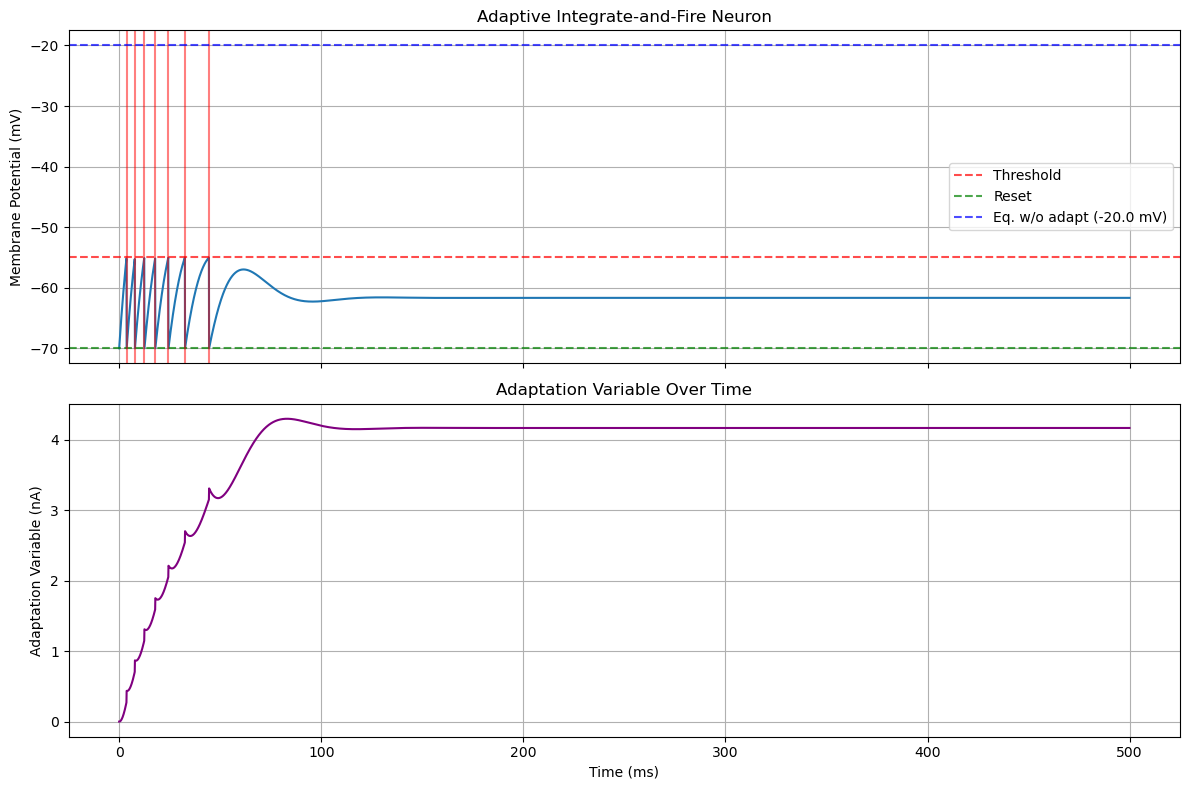

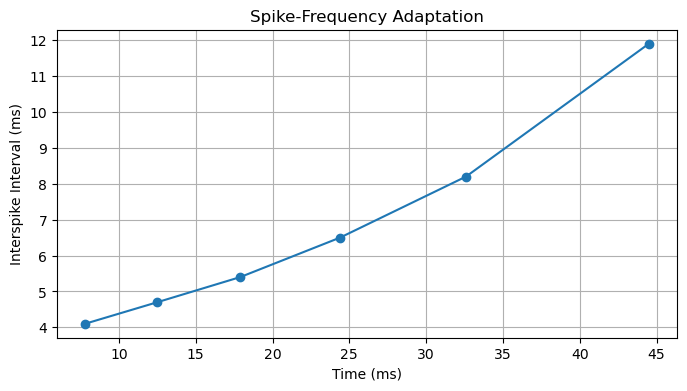

In [7]:
# Adaptive LIF neuron simulation
t_max = 500  # ms (longer simulation to see adaptation effects)
dt = 0.1     # ms
time_steps = np.arange(0, t_max, dt)

# Create adaptive neuron with higher input current to get more spikes
# Strong early adaptation - quick transition to steady firing rate
alif_neuron = ALIF(
    Cm=1,           # nF
    R=10,           # MΩ
    V_th=-55,       # mV
    V_reset=-70,    # mV
    V_rest=-70,     # mV
    I=5.0,          # nA (strong input)
    time_steps=time_steps,
    a=0.001,        # Moderate subthreshold adaptation
    tau_w=50,       # ms (faster decay)
    b=0.15          # nA (stronger spike-triggered adaptation)
)

# Run simulation
voltage, w, spikes = alif_neuron.simulate()

# Plot results
alif_neuron.plot_results(voltage, w, spikes)